# PBMC12k UMAP（raw counts / log1p）+ batch QC

此 notebook 使用 Scanpy 从 `.h5ad` 读取 PBMC12k 数据：

- 基于 **raw counts** 计算 UMAP，并按 batch 上色
- 从 raw counts 计算 QC 指标（`total_counts` / `n_genes_by_counts`），按 batch 对比
- 提供一份更常见的流程：`normalize_total + log1p + HVG` 后的 UMAP（同样按 batch 上色）

默认假设数据在仓库根目录下的 `data/PBMC12k.h5ad`（如文件名不同请修改 `data_path`）。

In [1]:
from __future__ import annotations

import os

from pathlib import Path

# 在部分环境下，numba/matplotlib 的默认 cache 目录可能不可写；这里显式指向 results/ 下
cache_root = Path("results/.cache")
numba_cache_dir = cache_root / "numba"
mpl_cache_dir = cache_root / "matplotlib"
numba_cache_dir.mkdir(parents=True, exist_ok=True)
mpl_cache_dir.mkdir(parents=True, exist_ok=True)
os.environ.setdefault("NUMBA_CACHE_DIR", str(numba_cache_dir.resolve()))
os.environ.setdefault("MPLCONFIGDIR", str(mpl_cache_dir.resolve()))

import numpy as np
import scanpy as sc
from scipy import sparse

sc.settings.verbosity = 3
sc.set_figure_params(dpi=120, facecolor="white")

print("cwd:", Path.cwd())
print("scanpy:", sc.__version__)
print("NUMBA_CACHE_DIR:", os.environ.get("NUMBA_CACHE_DIR"))
print("MPLCONFIGDIR:", os.environ.get("MPLCONFIGDIR"))

cwd: /data1021/xiepengyu/scVOTE/test
scanpy: 1.11.4
NUMBA_CACHE_DIR: /data1021/xiepengyu/scVOTE/test/results/.cache/numba
MPLCONFIGDIR: /data1021/xiepengyu/scVOTE/test/results/.cache/matplotlib


In [2]:
# 修改为你的数据路径（建议保持相对路径，便于在远程 / 本地一致运行）
data_path = Path("../data/PBMC12k.h5ad")

if not data_path.exists():
    raise FileNotFoundError(
        f"找不到数据文件: {data_path.resolve()}\n"
        "请把 PBMC12k 的 .h5ad 放到 data/ 下，或修改 data_path。"
    )

adata = sc.read_h5ad(data_path)
adata

AnnData object with n_obs × n_vars = 12721 × 33694
    obs: 'cell_type', 'batch'
    var: 'gene_ids'

In [3]:
def _is_integer_like_matrix(x, n_check: int = 50000, atol: float = 1e-8) -> bool:
    if sparse.issparse(x):
        data = x.data
    else:
        data = np.asarray(x).ravel()

    if data.size == 0:
        return True

    if data.size > n_check:
        rng = np.random.default_rng(0)
        data = rng.choice(data, size=n_check, replace=False)

    return np.all(np.abs(data - np.round(data)) < atol)


# 确保 raw counts 在 adata.layers['counts']：
# - 优先使用已有 counts layer
# - 否则尝试用 adata.raw.X（如果看起来像整数）
# - 最后退化为假设 adata.X 就是 counts
if "counts" in adata.layers:
    print("Found layer: adata.layers['counts']")
elif adata.raw is not None and _is_integer_like_matrix(adata.raw.X):
    adata.layers["counts"] = adata.raw.X
    print("Use adata.raw.X as counts -> adata.layers['counts']")
else:
    adata.layers["counts"] = adata.X
    print("Use adata.X as counts -> adata.layers['counts']")

counts_is_integer_like = _is_integer_like_matrix(adata.layers["counts"])
print("counts integer-like:", counts_is_integer_like)
if not counts_is_integer_like:
    print(
        "WARNING: 当前 counts 看起来不是 raw integer counts。"
        "\n请确认你的原始 counts 是否在 adata.layers（如 'counts'/'raw_counts'）或 adata.raw 中。"
    )

print("layers:", list(adata.layers.keys()))
print("obs columns:", list(adata.obs.columns))

Use adata.X as counts -> adata.layers['counts']
counts integer-like: True
layers: ['counts']
obs columns: ['cell_type', 'batch']


In [4]:
# batch 字段名：优先从常见命名里自动选择；如不匹配请手动改 batch_key
candidate_batch_keys = [
    "batch",
    "batch_id",
    "Batch",
    "orig.ident",
    "orig_ident",
    "sample",
    "library",
    "donor",
]

batch_key = next((k for k in candidate_batch_keys if k in adata.obs.columns), None)
if batch_key is None:
    raise KeyError(
        "未在 adata.obs 中找到常见 batch 字段。\n"
        f"当前 obs 列: {list(adata.obs.columns)}\n"
        "请手动设置 batch_key 为你的 batch 列名。"
    )

adata.obs[batch_key] = adata.obs[batch_key].astype("category")
print("batch_key:", batch_key)
adata.obs[batch_key].value_counts()

batch_key: batch


batch
PBMC8k    8381
PBMC4k    4340
Name: count, dtype: int64

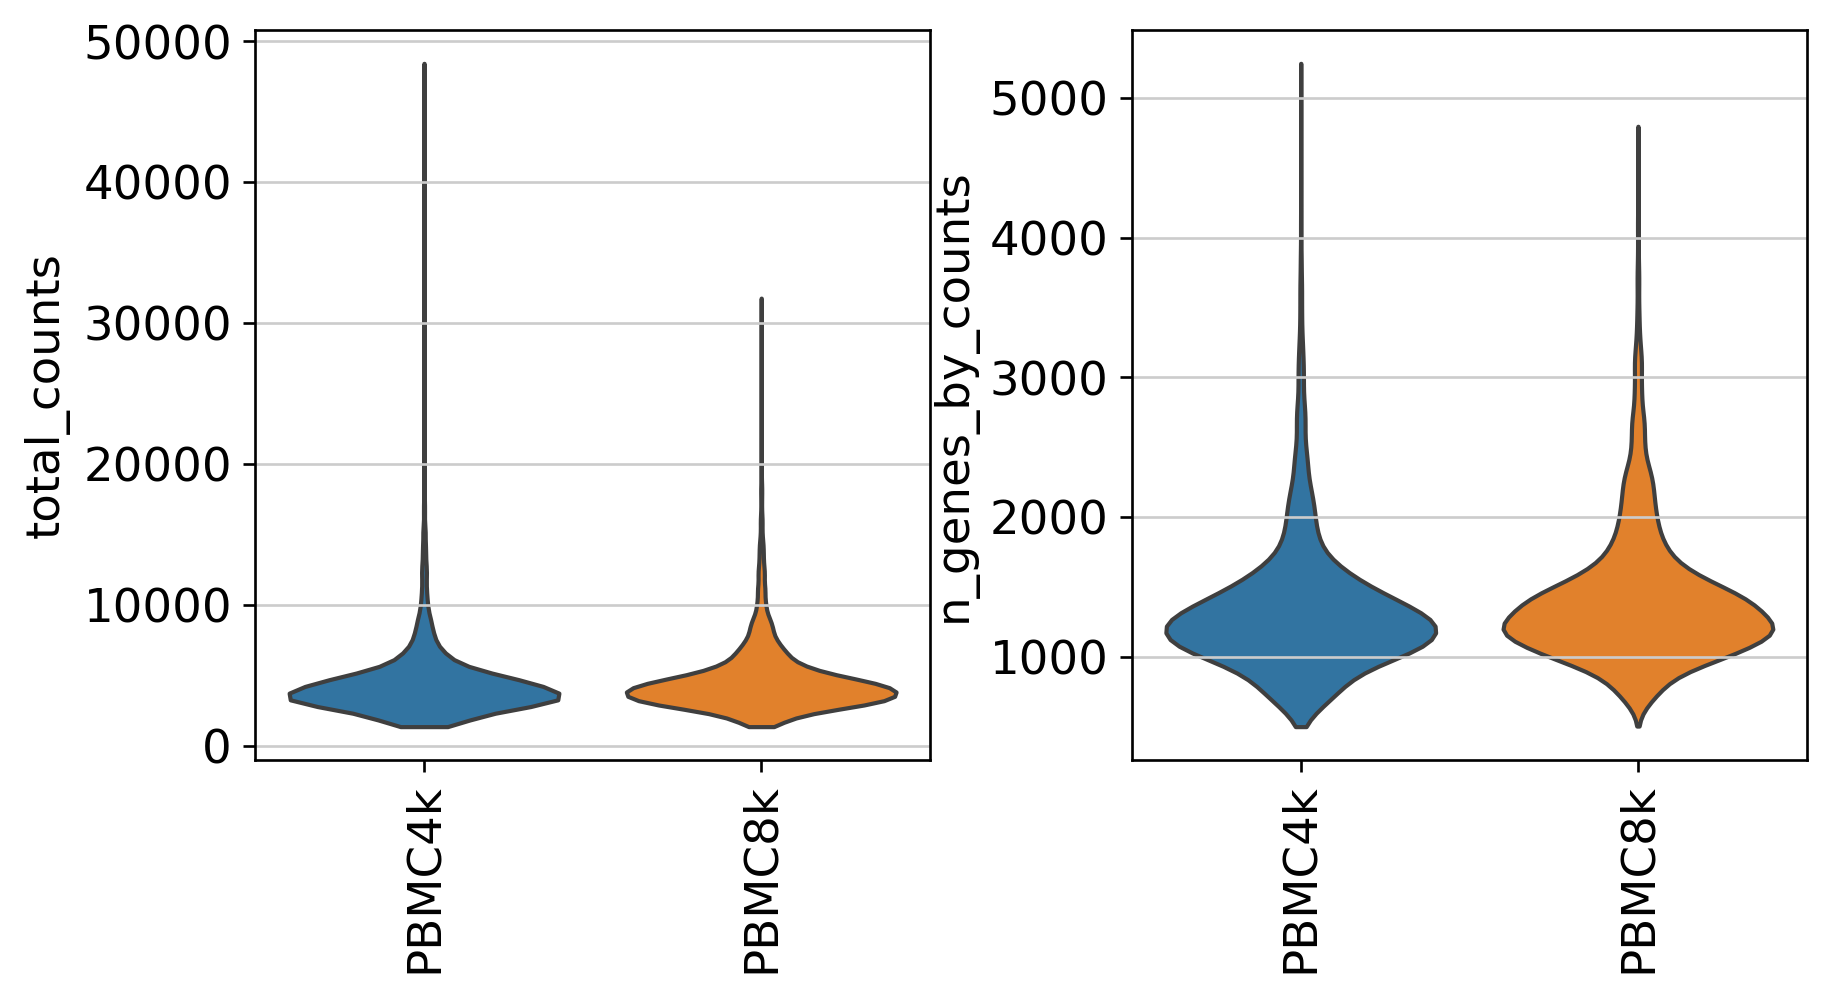

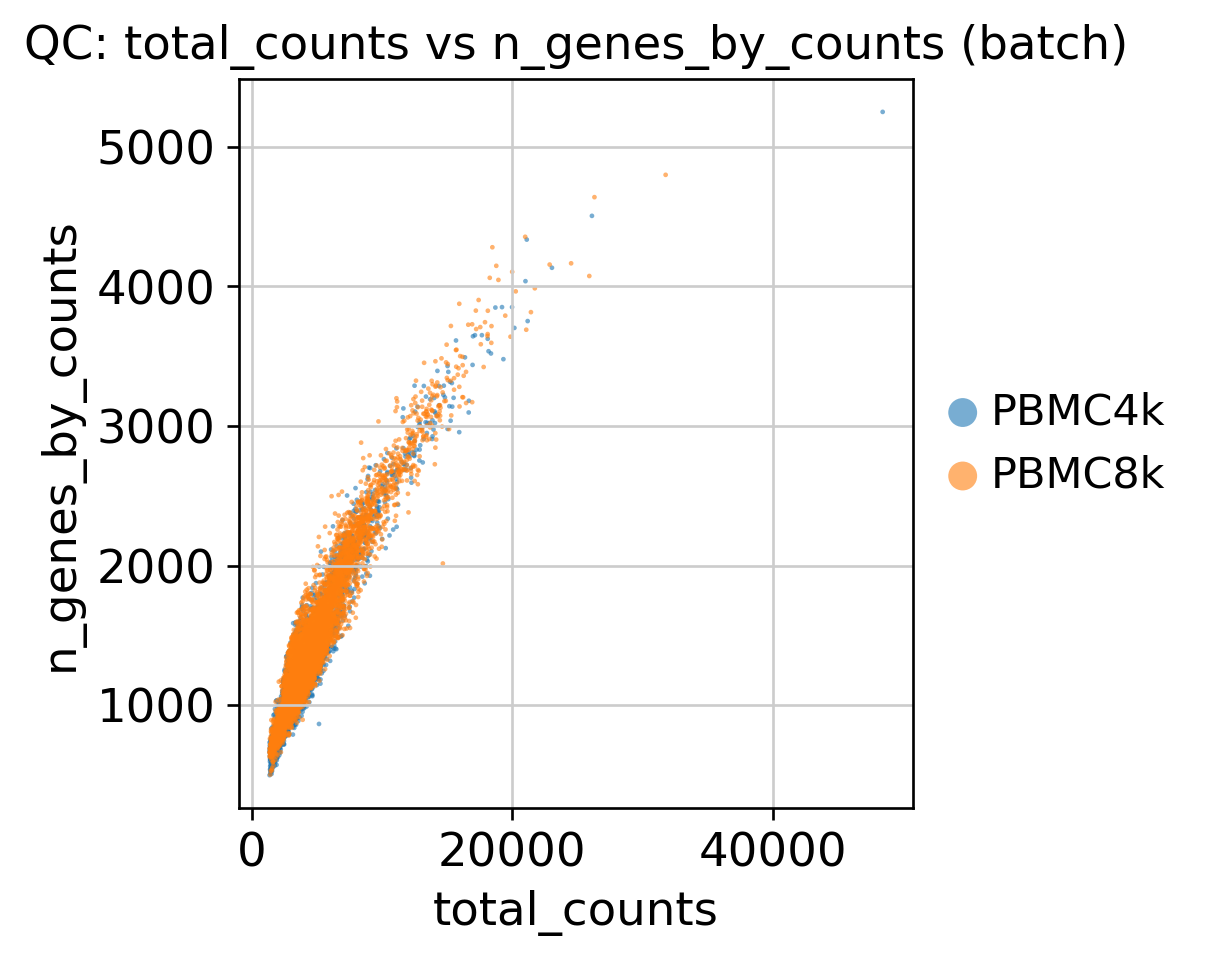

In [5]:
# QC（从 raw counts 计算），按 batch 对比
sc.pp.calculate_qc_metrics(
    adata,
    layer="counts",
    percent_top=None,
    log1p=False,
    inplace=True,
)

sc.pl.violin(
    adata,
    keys=["total_counts", "n_genes_by_counts"],
    groupby=batch_key,
    stripplot=False,
    jitter=False,
    rotation=90,
    multi_panel=True,
)

sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    color=batch_key,
    title=f"QC: total_counts vs n_genes_by_counts ({batch_key})",
    alpha=0.6,
    size=8,
)


computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50


/data1021/xiepengyu/miniconda3/envs/scvote/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:19)


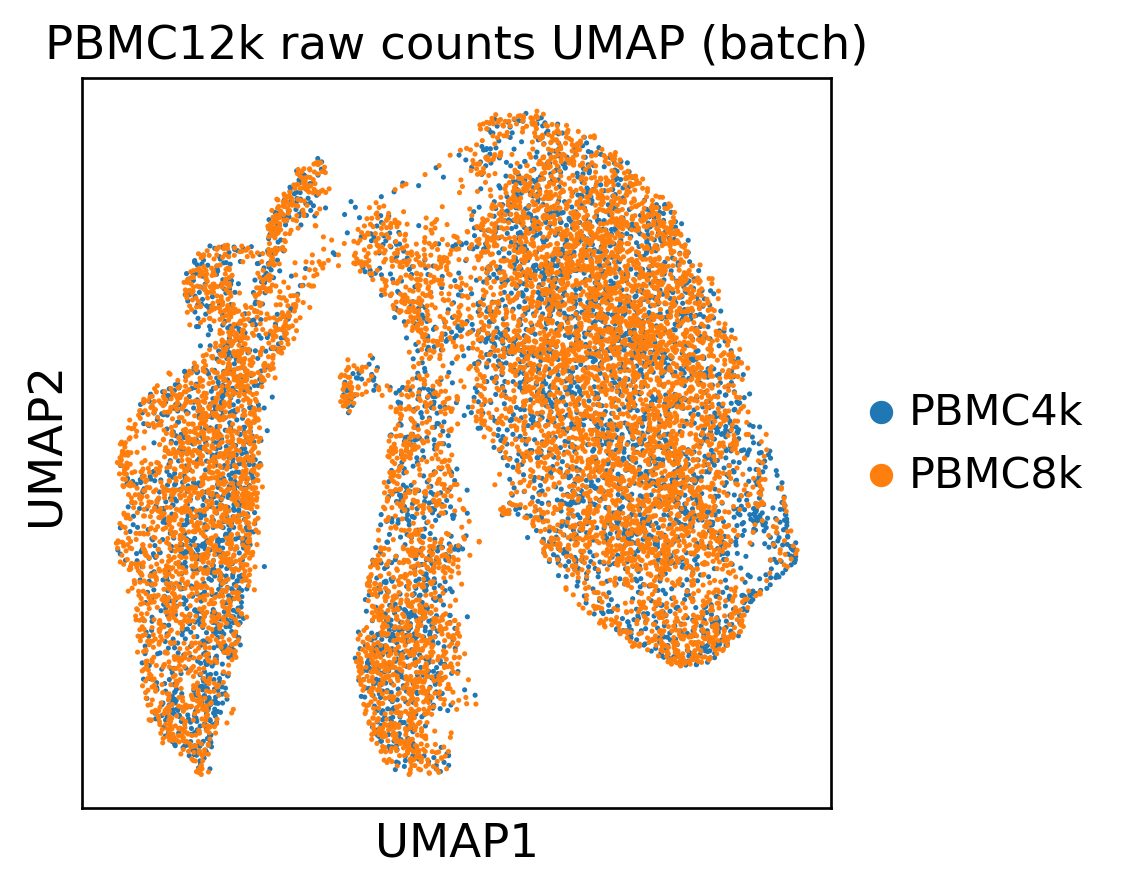

In [6]:
# 基于 raw counts 计算 UMAP
# 注意：raw counts 往往是稀疏矩阵；这里用 zero_center=False 避免 PCA 过程中 densify
sc.pp.pca(
    adata,
    n_comps=50,
    zero_center=False,
    svd_solver="arpack",
    layer="counts",
)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata, random_state=0)

sc.pl.umap(adata, color=batch_key, title=f"PBMC12k raw counts UMAP ({batch_key})")

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


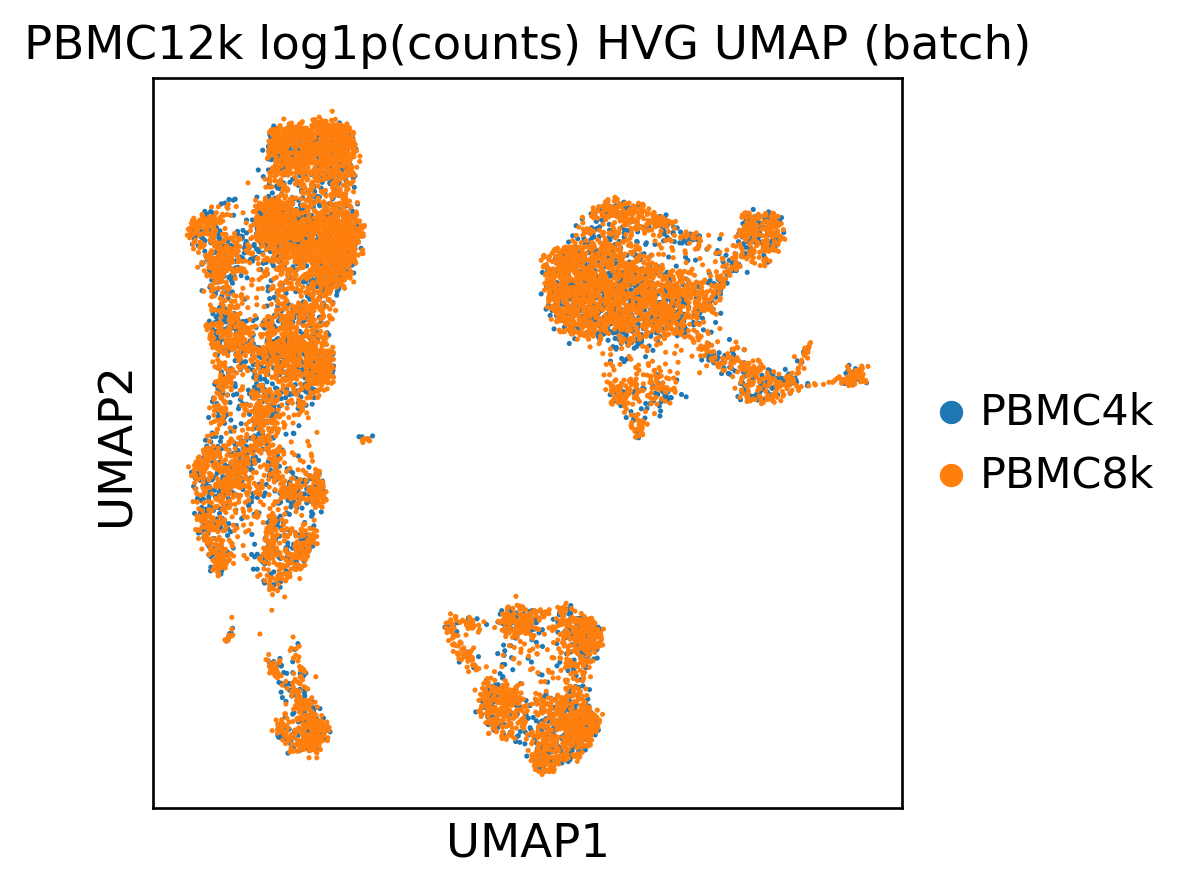

In [7]:
# 基于 counts -> normalize_total -> log1p -> HVG 的 UMAP（通常更稳定）
adata_log = adata.copy()
adata_log.X = adata_log.layers["counts"]

sc.pp.normalize_total(adata_log, target_sum=1e4)
sc.pp.log1p(adata_log)

sc.pp.highly_variable_genes(adata_log, n_top_genes=2000, subset=True)
sc.pp.pca(adata_log, n_comps=50, zero_center=False, svd_solver="arpack")
sc.pp.neighbors(adata_log, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_log, random_state=0)

sc.pl.umap(
    adata_log,
    color=batch_key,
    title=f"PBMC12k log1p(counts) HVG UMAP ({batch_key})",
)


In [8]:
# 可选：保存图片到 results/figures/
import matplotlib.pyplot as plt

out_dir = Path("results/figures")
out_dir.mkdir(parents=True, exist_ok=True)
raw_out_path = out_dir / "pbmc12k_rawcount_umap_batch.png"
log1p_out_path = out_dir / "pbmc12k_log1p_umap_batch.png"

ax = sc.pl.umap(
    adata,
    color=batch_key,
    title=f"PBMC12k raw counts UMAP ({batch_key})",
    show=False,
)
plt.savefig(raw_out_path, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", raw_out_path.resolve())

ax = sc.pl.umap(
    adata_log,
    color=batch_key,
    title=f"PBMC12k log1p(counts) HVG UMAP ({batch_key})",
    show=False,
)
plt.savefig(log1p_out_path, dpi=300, bbox_inches="tight")
plt.close()
print("Saved:", log1p_out_path.resolve())

Saved: /data1021/xiepengyu/scVOTE/test/results/figures/pbmc12k_rawcount_umap_batch.png
Saved: /data1021/xiepengyu/scVOTE/test/results/figures/pbmc12k_log1p_umap_batch.png
